In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from math import ceil

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Helper functions to calculate metrics

In [2]:
from findpeaks import findpeaks
from scipy.ndimage.measurements import label

In [3]:
# Area and Peaks

def get_area_and_peaks(firing_field):
    firing_field = firing_field/firing_field.max()
    area_thresh = ceil(0.00716197244*firing_field.size)
    masked_field = firing_field > 0.8
    labeled_array, ncomponents = label(masked_field, np.ones((3,3)))
    areas = []
    for label_id in np.unique(labeled_array):
        if label_id == 0: continue
        area = np.sum(labeled_array == label_id)
        if area < area_thresh: continue
        areas.append(area)
    return areas, len(areas)

# Spatial Info

def flatten_xy(walk_xs, walk_ys):
    max_col = walk_ys.max()
    new_bins = walk_xs * max_col + walk_ys
    return new_bins

def circular(fr):
    """
    Circularly shuffles a (neur, frames) array of firing rates, neuron by neuron.
    """

    fr = fr.copy()
    shift = np.random.choice(np.arange(1, fr.size))
    if len(fr.shape) == 2:
        num_neur, num_frames = fr.shape
        for neur in range(num_neur):
            shift = np.random.choice(np.arange(1, num_frames))
            fr[neur,:] = np.roll(fr[neur,:], shift)
        return fr
    else:
        return np.roll(fr, shift)
    
def get_mutual_info(conditions, fr):
    """
    Calculates mutual information between firing rate and a set of conditions

    Args:
        conditions: (frames,) array of conditions
        fr: (neurs, frames) array of firing rates
    Returns:
        (neurs,) array of scaler value mutual information per neuron
    """

    num_neurs, _ = fr.shape
    mean_fr = np.mean(fr, axis=1)
    mutual_info = np.zeros(num_neurs)
    for condn in np.unique(conditions):
        prob = np.sum(conditions==condn)/conditions.size
        condn_mean_fr = np.mean(fr[:,conditions==condn], axis=1)
        log_term = np.log2(condn_mean_fr/mean_fr)
        log_term[np.isnan(log_term)] = 0
        log_term[np.isinf(log_term)] = 0
        mutual_info += prob*condn_mean_fr*log_term
    return mutual_info

def calc_place_cells(xs, ys, fr, num_shuffles):
    """ Gets the spatial mutual information of each cell."""

    num_neurs, num_frames = fr.shape
    spatial_info = np.zeros(num_neurs)
    significance = np.zeros(num_neurs)
    conditions = flatten_xy(xs, ys)
    spatial_info = get_mutual_info(conditions, fr)
    
    for _ in range(num_shuffles):
        shuffled_fr = circular(fr)
        shuffled_info = get_mutual_info(conditions, shuffled_fr)
        significance += (shuffled_info < spatial_info)
    significance /= num_shuffles
    
    return spatial_info, significance

def get_metrics(outputs, dset):
    walk_xs = dset.xs.astype(int)
    walk_ys = dset.ys.astype(int)
    arena_length = 10
    
    areas = []
    ncomps = []

#     spatial_info, significance = calc_place_cells(
#         walk_xs, walk_ys, outputs.T, 100
#         )

    for neur in np.arange(outputs.shape[1]):
        firing_field = np.zeros((arena_length, arena_length))*np.nan
        for x in range(arena_length):
            for y in range(arena_length):
                frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
                fr = np.nanmean(outputs[frame_idxs, neur])
                firing_field[x,y] = fr
        num_nonnans = firing_field.size - np.sum(np.isnan(firing_field))
        firing_field[np.isnan(firing_field)] = 0

        # Area?
        area, ncomp = get_area_and_peaks(firing_field)
        areas.append(np.sum(area)/num_nonnans)
        ncomps.append(ncomp)
    return np.array(areas), np.array(ncomps), None

# Specify dataset

In [4]:
num_states = 14*14

In [5]:
# N-hot inputs
feature_maker_kwargs = {
    'feature_dim': num_states*2, 'feature_type': 'nhot'
    }

# Uncorrelated inputs
feature_maker_kwargs = {
    'feature_dim': num_states,
    'feature_vals': [0, 1],
    'feature_vals_p': [0.97, 0.03]
    }

# Correlated inputs
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_vals': None,
    'feature_vals_p': [0.8, 0.2],
    'feature_type': 'correlated_distributed',
    'spatial_sigma': 1.75
    }

# # One hot
# feature_maker_kwargs = {
#     'feature_dim': num_states, 'feature_type': 'nhot'
#     }

dataset_config = {
    'num_steps': 3500, 'num_states': num_states,
    'feature_maker_kwargs': feature_maker_kwargs
    }
dataset = sf_inputs_discrete.Sim2DWalk


dataset_config = {
    'feature_maker_kwargs': feature_maker_kwargs,
    'num_steps': np.inf
    }
dataset = sf_inputs_discrete.TitmouseWalk

input_size = feature_maker_kwargs['feature_dim']

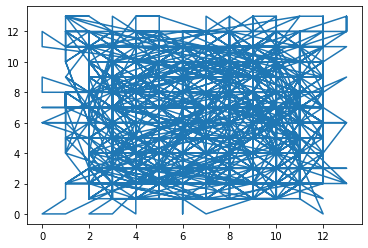

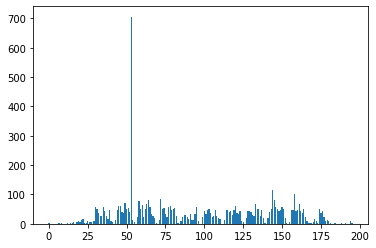

23.5


0.10714285714285714

In [6]:
input = dataset(**dataset_config)
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

plt.figure();
states = np.argwhere(input.state_inputs)[:,0]
counts = np.zeros(input.num_states)
for state in np.arange(input.num_states):
    counts[state] = np.sum(states==state)
plt.bar(np.arange(input.num_states), counts)
plt.show()
print(np.median(counts))
np.sum(counts == 0)/input.num_states

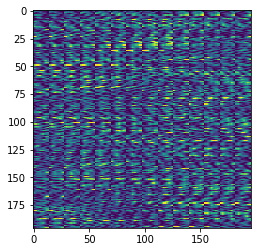

In [9]:
plt.figure()
plt.imshow(input.feature_maker.feature_map)
plt.show()

In [10]:
gamma=0.6

In [11]:
areas = []
nfields = []
one_fields = []

for _ in range(5):
    rnn = AnalyticSR(
        num_states=input_size, gamma=gamma,
        ca3_kwargs={
            'use_dynamic_lr':False, 'lr': 5E-2,
            #'parameterize': True,
            'alpha': 1.2, 'beta': 1.2
            }
        )
    outputs, loss, dset = run_rnn(
        '../trained_models/test/', rnn, dataset,
        dataset_config, gamma=gamma, test_over_all=False,
        train_net=False, return_dset=True
        )
    walk_xs = dset.xs
    walk_ys = dset.ys
    arena_length = int(np.sqrt(dset.num_states))
    _areas, _ncomps, _ = get_metrics(outputs, dset)
    areas.append(np.mean(_areas))
    nfields.append(np.mean(_ncomps))
    one_fields.append(sum(_ncomps==1)/_ncomps.size)


[   51] loss: 0.030
Time per step 0.057s, net 2.861s

[  101] loss: 0.029
Time per step 0.059s, net 5.827s

[  151] loss: 0.029
Time per step 0.057s, net 8.656s

[  201] loss: 0.030
Time per step 0.056s, net 11.449s

[  251] loss: 0.031
Time per step 0.061s, net 14.516s

[  301] loss: 0.031
Time per step 0.061s, net 17.561s

[  351] loss: 0.031
Time per step 0.055s, net 20.332s

[  401] loss: 0.030
Time per step 0.055s, net 23.094s

[  451] loss: 0.031
Time per step 0.054s, net 25.808s

[  501] loss: 0.029
Time per step 0.054s, net 28.531s

[  551] loss: 0.031
Time per step 0.055s, net 31.266s

[  601] loss: 0.030
Time per step 0.055s, net 33.996s

[  651] loss: 0.030
Time per step 0.055s, net 36.723s

[  701] loss: 0.031
Time per step 0.058s, net 39.618s

[  751] loss: 0.032
Time per step 0.054s, net 42.341s

[  801] loss: 0.030
Time per step 0.055s, net 45.089s

[  851] loss: 0.030
Time per step 0.059s, net 48.053s

[  901] loss: 0.032
Time per step 0.059s, net 50.987s

[  951] loss


[ 1551] loss: 0.030
Time per step 0.081s, net 119.948s

[ 1601] loss: 0.030
Time per step 0.088s, net 124.358s

[ 1651] loss: 0.027
Time per step 0.089s, net 128.812s

[ 1701] loss: 0.029
Time per step 0.088s, net 133.187s

[ 1751] loss: 0.030
Time per step 0.077s, net 137.062s

[ 1801] loss: 0.030
Time per step 0.079s, net 141.025s

[ 1851] loss: 0.030
Time per step 0.081s, net 145.080s

[ 1901] loss: 0.028
Time per step 0.080s, net 149.074s

[ 1951] loss: 0.027
Time per step 0.077s, net 152.905s

[ 2001] loss: 0.029
Time per step 0.081s, net 156.937s

[ 2051] loss: 0.028
Time per step 0.059s, net 159.871s

[ 2101] loss: 0.028
Time per step 0.055s, net 162.604s

[ 2151] loss: 0.030
Time per step 0.054s, net 165.326s

[ 2201] loss: 0.030
Time per step 0.055s, net 168.053s

[ 2251] loss: 0.030
Time per step 0.056s, net 170.855s

[ 2301] loss: 0.030
Time per step 0.055s, net 173.595s

[ 2351] loss: 0.030
Time per step 0.063s, net 176.729s

[ 2401] loss: 0.029
Time per step 0.059s, net 1


[ 3901] loss: 0.002
Time per step 0.046s, net 172.494s

[ 3951] loss: 0.002
Time per step 0.045s, net 174.763s

[ 4001] loss: 0.002
Time per step 0.046s, net 177.054s

[ 4051] loss: 0.002
Time per step 0.045s, net 179.323s

[ 4101] loss: 0.002
Time per step 0.046s, net 181.628s
SVD did not converge. Small values added on diagonal.
SVD did not converge. Small values added on diagonal.

[ 4151] loss: 0.002
Time per step 0.050s, net 184.103s

[ 4201] loss: 0.002
Time per step 0.045s, net 186.377s

[ 4251] loss: 0.002
Time per step 0.045s, net 188.647s

[ 4301] loss: 0.002
Time per step 0.046s, net 190.923s

[ 4351] loss: 0.002
Time per step 0.046s, net 193.207s

[ 4401] loss: 0.002
Time per step 0.046s, net 195.494s

[ 4451] loss: 0.002
Time per step 0.047s, net 197.830s

[ 4501] loss: 0.002
Time per step 0.046s, net 200.124s

[ 4551] loss: 0.002
Time per step 0.046s, net 202.427s

[ 4601] loss: 0.002
Time per step 0.045s, net 204.691s
SVD did not converge. Small values added on diagonal

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars



[   51] loss: 0.020
Time per step 0.051s, net 2.544s

[  101] loss: 0.017
Time per step 0.053s, net 5.212s

[  151] loss: 0.024
Time per step 0.053s, net 7.865s

[  201] loss: 0.025
Time per step 0.053s, net 10.538s

[  251] loss: 0.024
Time per step 0.054s, net 13.214s

[  301] loss: 0.031
Time per step 0.054s, net 15.892s

[  351] loss: 0.026
Time per step 0.054s, net 18.581s

[  401] loss: 0.024
Time per step 0.054s, net 21.274s

[  451] loss: 0.027
Time per step 0.056s, net 24.070s

[  501] loss: 0.025
Time per step 0.054s, net 26.747s

[  551] loss: 0.030
Time per step 0.054s, net 29.439s

[  601] loss: 0.026
Time per step 0.054s, net 32.115s

[  651] loss: 0.030
Time per step 0.054s, net 34.791s

[  701] loss: 0.028
Time per step 0.053s, net 37.462s

[  751] loss: 0.031
Time per step 0.054s, net 40.143s

[  801] loss: 0.033
Time per step 0.054s, net 42.822s

[  851] loss: 0.029
Time per step 0.053s, net 45.492s

[  901] loss: 0.032
Time per step 0.053s, net 48.165s

[  951] loss


[ 4301] loss: 0.032
Time per step 0.054s, net 231.193s

[ 4351] loss: 0.033
Time per step 0.054s, net 233.872s

[ 4401] loss: 0.032
Time per step 0.054s, net 236.557s

[ 4451] loss: 0.034
Time per step 0.053s, net 239.218s

[ 4501] loss: 0.034
Time per step 0.053s, net 241.875s

[ 4551] loss: 0.033
Time per step 0.053s, net 244.548s

[ 4601] loss: 0.032
Time per step 0.053s, net 247.221s

[ 4651] loss: 0.032
Time per step 0.053s, net 249.888s

[ 4701] loss: 0.032
Time per step 0.053s, net 252.561s

[ 4751] loss: 0.032
Time per step 0.053s, net 255.227s

[ 4801] loss: 0.032
Time per step 0.053s, net 257.902s

[ 4851] loss: 0.034
Time per step 0.053s, net 260.571s

[ 4901] loss: 0.035
Time per step 0.053s, net 263.244s

[ 4951] loss: 0.033
Time per step 0.054s, net 265.931s

[ 5001] loss: 0.031
Time per step 0.053s, net 268.601s

[ 5051] loss: 0.031
Time per step 0.054s, net 271.276s

[ 5101] loss: 0.034
Time per step 0.053s, net 273.950s

[ 5151] loss: 0.032
Time per step 0.054s, net 2

In [12]:
print(np.nanmean(areas))
areas

0.08209298160886215


[0.08964285714285715,
 0.08936301793444651,
 nan,
 0.07078410311493018,
 0.07858194824321481]

In [15]:
print(np.mean(nfields[nfields!=0]))
nfields

1.5357142857142858


[1.4540816326530612,
 1.5357142857142858,
 0.0,
 1.530612244897959,
 1.5459183673469388]

In [17]:
print(np.mean(one_fields[one_fields!=0]))
one_fields

0.5459183673469388


[0.6173469387755102,
 0.5459183673469388,
 0.0,
 0.5867346938775511,
 0.5816326530612245]

# Make Firing Field Plots

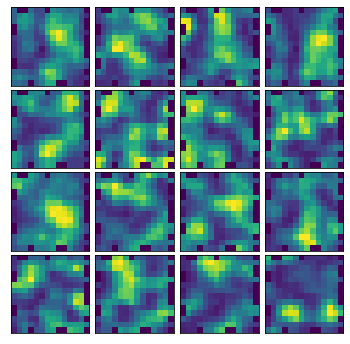

In [41]:
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0    
    if not np.any(firing_field > 0): continue
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    area, ncomp = get_area_and_peaks(firing_field)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.show()